## **<h3 align="center"> Deep Learning - Project </h3>**
# **<h3 align="center"> Phylum Cnidaria - Tim </h3>**
**Group 4 members:**<br>
Alexandra Pinto - 20211599@novaims.unl.pt - 20211599<br>
Steven Carlson - 20240554@novaims.unl.pt - 20240554<br>
Sven Goerdes - 20240503@novaims.unl.pt - 20240503<br>
Tim Straub - 20240505@novaims.unl.pt - 20240505<br>
Zofia Wojcik  - 20240654@novaims.unl.pt - 20240654<br>

# Table of Contents
* [1. Introduction](#intro)
* [2. Setup](#setup)
* [3. Data Loading](#dataloading)
* [4. Image Preprocessing](#imagepreprocessing)
* [5. Neural Networks Models](#nnmodels)



# 1. Introduction <a class="anchor" id="intro"></a>

In this third notebook, we will preprocess images from the **Chordata** phylum and develop a deep learning model to accurately classify them at the family level.

# 2. Setup <a class="anchor" id="setup"></a>
In this section, we will import the necessary libraries that will be used throughout the notebook. These libraries will help with data handling and image processing.

In [63]:
# Standard libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import zipfile
import seaborn as sns

# Libraries for image processing
from glob import glob
from PIL import Image

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras import layers, models, optimizers

In [64]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth set for GPUs")
    except RuntimeError as e:
        print(e)


Memory growth set for GPUs


# 3. Data Loading <a class="anchor" id="dataloading"></a>

Let's open the train and test for Chordata Phylum.

In [65]:
# Load the DataFrame from the CSV file
cnidaria_train = pd.read_pickle("train_test_splits/cnidaria_train_processed.pkl")
cnidaria_train.head(3)

,eol_content_id,eol_page_id,kingdom,phylum,family,file_path,resized_image,clahe_image,noBackground_image,has_black_background,mixed_image
0,28219388,45276311,animalia,cnidaria,acroporidae,cnidaria_acroporidae/28219388_45276311_eol-ful...,"[[[76, 74, 71], [73, 70, 71], [74, 71, 72], [7...","[[[72, 70, 67], [57, 53, 54], [58, 56, 57], [8...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",False,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
1,29729570,45276321,animalia,cnidaria,acroporidae,cnidaria_acroporidae/29729570_45276321_eol-ful...,"[[[202, 202, 170], [195, 186, 156], [209, 197,...","[[[157, 157, 126], [135, 128, 100], [158, 149,...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",False,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
2,20332243,46545536,animalia,cnidaria,lobophylliidae,cnidaria_lobophylliidae/20332243_46545536_eol-...,"[[[8, 159, 90], [9, 183, 111], [2, 212, 128], ...","[[[0, 78, 19], [0, 113, 49], [0, 185, 103], [0...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",False,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."


In [66]:
# Load the DataFrame from the CSV file
cnidaria_test = pd.read_pickle("train_test_splits/cnidaria_test_processed.pkl")
cnidaria_test.head(3)

,eol_content_id,eol_page_id,kingdom,phylum,family,file_path,resized_image,clahe_image,noBackground_image,has_black_background,mixed_image
0,21699228,45276518,animalia,cnidaria,agariciidae,cnidaria_agariciidae/21699228_45276518_eol-ful...,"[[[81, 148, 190], [83, 150, 192], [84, 151, 19...","[[[85, 152, 193], [94, 160, 202], [94, 160, 20...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",True,"[[[85, 152, 193], [94, 160, 202], [94, 160, 20..."
1,2746810,45276959,animalia,cnidaria,siderastreidae,cnidaria_siderastreidae/2746810_45276959_eol-f...,"[[[192, 220, 224], [193, 221, 225], [193, 221,...","[[[122, 147, 151], [124, 149, 153], [124, 149,...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",False,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
2,29729172,45276583,animalia,cnidaria,fungiidae,cnidaria_fungiidae/29729172_45276583_eol-full-...,"[[[128, 147, 84], [49, 62, 51], [50, 61, 71], ...","[[[183, 203, 137], [12, 25, 14], [15, 27, 36],...","[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",False,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."


In [67]:
cnidaria_train.shape, cnidaria_test.shape

((647, 11), (162, 11))

In [68]:
cnidaria_train['family'].value_counts()

family
acroporidae         168
agariciidae          95
euphylliidae         72
faviidae             48
merulinidae          48
pocilloporidae       48
helioporidae         24
lobophylliidae       24
dendrophylliidae     24
siderastreidae       24
fungiidae            24
diploastraeidae      24
meandrinidae         24
Name: count, dtype: int64

In [69]:
cnidaria_train["family"].nunique()

13

In [70]:
# 1) Build the label→index map from the train families
label_to_index = {
    label: idx 
    for idx, label in enumerate(sorted(cnidaria_train["family"].unique()))
}

# 2) Convert DataFrame columns to NumPy arrays
X_train = np.stack(cnidaria_train["clahe_image"].values).astype("float32") / 255.0
y_train = np.array([label_to_index[label] for label in cnidaria_train["family"]])

X_test  = np.stack(cnidaria_test["clahe_image"].values).astype("float32") / 255.0
y_test  = np.array([label_to_index[label] for label in cnidaria_test["family"]])

print("X_train shape:", X_train.shape)  # (num_train_samples, 224, 224, 3)
print("X_test shape: ", X_test.shape)   # (num_test_samples, 224, 224, 3)

# 3) Create TensorFlow Datasets (no validation split)
batch_size = 8
AUTOTUNE   = tf.data.AUTOTUNE

train_ds = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train))
    .shuffle(buffer_size=len(X_train), seed=42)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

test_ds = (
    tf.data.Dataset.from_tensor_slices((X_test, y_test))
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

X_train shape: (647, 224, 224, 3)
X_test shape:  (162, 224, 224, 3)


In [71]:
# import numpy as np
# import tensorflow as tf
# import pandas as pd
# from sklearn.model_selection import train_test_split

# # --- Assume your DataFrame columns are already set ---
# # cnidaria_train contains:
# #   - "noBackground_image": preprocessed image arrays (shape [224,224,3] for each)
# #   - "family": the family label as a string
# # And label_to_index and label_names are already defined.

# def

# # Convert the "noBackground_image" column to a stacked NumPy array for training and test images:
# X_train = np.stack(cnidaria_train["noBackground_image"].values)
# y_train = np.array([label_to_index[label] for label in cnidaria_train["family"]])

# X_test  = np.stack(cnidaria_test["noBackground_image"].values)
# y_test  = np.array([label_to_index[label] for label in cnidaria_test["family"]])

# print("X_train shape:", X_train.shape)  # Should be (num_samples, 224, 224, 3)
# print("X_test shape:", X_test.shape)

# # --- Split Training Data into Train and Validation Sets (80/20 split) ---
# X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# print("Training set size:", X_tr.shape[0])
# print("Validation set size:", X_val.shape[0])

# # --- Create TensorFlow Datasets from the NumPy Arrays ---

# # For training dataset:
# train_ds = tf.data.Dataset.from_tensor_slices((X_tr, y_tr))
# train_ds = train_ds.shuffle(buffer_size=len(X_tr), seed=42)
# train_ds = train_ds.batch(8).prefetch(tf.data.AUTOTUNE)

# # For validation dataset:
# val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
# val_ds = val_ds.batch(8).prefetch(tf.data.AUTOTUNE)

# # For test dataset:
# test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
# test_ds = test_ds.batch(8).prefetch(tf.data.AUTOTUNE)




# 4. Image Preprocessing <a class="anchor" id="imagepreprocessing"></a>

## 4.2 Advanced Preprocessing

In [72]:
#Define model shape
num_classes = cnidaria_train['family'].nunique() #number of classes = number of families
batch_size = 32
input_shape = (224, 224, 3)
image_size = (224, 224)
value_range = (0.0, 1.0)

### Augmentation

In [73]:
#Function to augment the images
def augment_image(image, label):

    #Randomly change brightness
    image = tf.image.random_brightness(image, max_delta=0.2)

    #Apply geometric augmentations
    image = geometric_augmentation_layers(image, training=True) # Apply geometric augmentations
    image = tf.clip_by_value(image, 0.0, 1.0)
    
    return image, label


# Geometric augmentations
geometric_augmentation_layers = tf.keras.Sequential(
    [
        # Randomly flip horizontally
        tf.keras.layers.RandomFlip("horizontal"),

        # Randomly rotate
        tf.keras.layers.RandomRotation(factor=0.12),

        # Random zoom
        tf.keras.layers.RandomZoom(height_factor=(-0.35, 0.35), # Corresponds to [0.8, 1.2] of original height
                                   width_factor=(-0.35, 0.35)), # Corresponds to [0.8, 1.2] of original width

        # Random shift
        tf.keras.layers.RandomTranslation(height_factor=0.20,
                                          width_factor=0.20),

        # Contrast
        tf.keras.layers.RandomContrast(factor=0.25),

    ],
    name="geometric_augmentations",
)

### CLAHE: Contrast Limited Adaptive Histogram Equalization  <a class="anchor" id="clahe"></a>

CLAHE improves local contrast by equalizing pixel values in small regions of the image. Ideal for biological datasets where detail visibility is key.
Studies:
- https://www.sciencedirect.com/science/article/pii/S2212440323001177
- https://arxiv.org/abs/2003.10822

In [74]:
# import cv2

# def process_image_with_clahe(image_path, size=(224, 224)):
#     """
#     Loads an image, resizes it, and applies CLAHE.
#     Returns the resized image and the CLAHE-enhanced version.
#     """
#     try:
#         img = cv2.imread(image_path)
#         if img is None:
#             print(f"❌ Failed to load: {image_path}")
#             return None, None

#         # Convert to RGB
#         img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#         # Resize
#         resized_img = cv2.resize(img_rgb, size, interpolation=cv2.INTER_AREA)

#         # Convert to LAB and apply CLAHE
#         lab = cv2.cvtColor(resized_img, cv2.COLOR_RGB2LAB)
#         l, a, b = cv2.split(lab)
#         clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(8, 8))
#         l_clahe = clahe.apply(l)
#         lab_clahe = cv2.merge((l_clahe, a, b))
#         img_clahe = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2RGB)

#         return resized_img, img_clahe

#     except Exception as e:
#         print(f"⚠️ Error processing {image_path}: {e}")
#         return None, None


In [75]:
# chordata_train[["resized_image", "image_clahe"]] = chordata_train["file_path"].progress_apply(
#     lambda path: pd.Series(process_image_with_clahe(os.path.join(image_folder, path)))
# )

In [76]:
# chordata_train.shape

Let's display the images to check if its working.

In [77]:
# def show_random_image_triplets(df, image_folder="rare_species", baseline_column="resized_image", clahe_column="image_clahe", num_samples=10):
#     """
#     Displays random triplets of original, baseline preprocessed, and CLAHE-enhanced images.

#     Args:
#         df (pd.DataFrame): DataFrame with image paths, baseline images, and CLAHE images.
#         image_folder (str): Folder containing the original images.
#         baseline_column (str): Column with preprocessed baseline images.
#         clahe_column (str): Column with CLAHE-enhanced images.
#         num_samples (int): Number of samples to display.
#     """
#     sample_df = df.sample(n=num_samples).reset_index(drop=True)

#     # Set up the plot (3 columns: Original, Baseline, CLAHE)
#     fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4 * num_samples))
#     if num_samples == 1:
#         axes = [axes]  # Make it iterable

#     for i in range(num_samples):
#         row = sample_df.loc[i]
#         file_path = os.path.join(image_folder, row["file_path"])

#         try:
#             # Load original from file
#             original_img = Image.open(file_path).convert("RGB")
#             baseline_img = row[baseline_column]
#             clahe_img = row[clahe_column]

#             if baseline_img is None or clahe_img is None:
#                 raise ValueError("Missing image in baseline or CLAHE")

#             # Original
#             axes[i][0].imshow(original_img)
#             axes[i][0].set_title("Original Image")
#             axes[i][0].axis("off")

#             # Baseline
#             axes[i][1].imshow(baseline_img)
#             axes[i][1].set_title("Baseline Image")
#             axes[i][1].axis("off")

#             # CLAHE
#             axes[i][2].imshow(clahe_img)
#             axes[i][2].set_title("CLAHE Image")
#             axes[i][2].axis("off")

#         except Exception as e:
#             print(f"❌ Error displaying image {file_path}: {e}")
#             for j in range(3):
#                 axes[i][j].axis("off")

#     plt.tight_layout()
#     plt.show()
# # Show random triplets of images
# show_random_image_triplets(chordata_train, num_samples=5)


### Pre-Process Pipeline

In [78]:
#Function to preprocess the images
def process_image(image, label):
    # image = tf.io.read_file(file_path) # Read the image file
    # image = tf.image.decode_jpeg(image, channels=3) # Decode the JPEG image
    # image = tf.image.resize(image, image_size) # Resize the image to the target size
    image = tf.cast(image, tf.float32) / 255.0
    
    #CHANGE THIS LINE DEPENDING ON WHICH PRE-TRAINED MODEL IS BEING USED
    
    #image = resnet_preprocess(image)  # Apply ResNet50 preprocessing
    image = mobilenet_preprocess(image)  # Apply MobileNetV2 preprocessing
    #image = efficientnet_preprocess(image)  # Apply EfficientNetB0 preprocessing
    #image = densenet_preprocess(image)  # Apply DenseNet121 preprocessing
    #image = inception_preprocess(image)  # Apply InceptionV3 preprocessing
    #image = tf.cast(image, tf.float32) / 255.0  # Apply ConvNeXt
    return image, label

In [79]:
import tensorflow as tf
import os

# --- 1) Build a raw, unbatched dataset from X_train/y_train ---
raw_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
raw_ds = raw_ds.shuffle(buffer_size=len(X_train), seed=42)

# --- 2) Identify minority class indices as int64 to match y_train’s dtype ---
minority_threshold   = 24
family_counts        = cnidaria_train['family'].value_counts()
minority_families    = family_counts[family_counts <= minority_threshold].index
minority_indices     = [label_to_index[f] for f in minority_families if f in label_to_index]
minority_indices_tf  = tf.constant(minority_indices, dtype=raw_ds.element_spec[1].dtype)

# --- 3) Split raw_ds into minority vs. majority (on scalar labels) ---
minority_ds = raw_ds.filter(
    lambda img, lbl: tf.reduce_any(tf.equal(lbl, minority_indices_tf))
)
majority_ds = raw_ds.filter(
    lambda img, lbl: tf.logical_not(tf.reduce_any(tf.equal(lbl, minority_indices_tf)))
)

# --- 4) Oversample minority ---
oversample_factor = 2
minority_ds = minority_ds.repeat(oversample_factor)

# --- 5) Re‑combine and reshuffle ---
train_ds = majority_ds.concatenate(minority_ds)
train_ds = train_ds.shuffle(buffer_size=len(X_train) + len(minority_indices)*oversample_factor, 
                            reshuffle_each_iteration=True, 
                            seed=42)

# --- 6) Apply your preprocess → augment → batch → prefetch ---
train_ds = train_ds.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.cache()
train_ds = train_ds.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.batch(8).prefetch(tf.data.AUTOTUNE)

# --- 7) Build the test pipeline the same way (no oversampling) ---
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_ds = test_ds.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(8).prefetch(tf.data.AUTOTUNE)


In [80]:
# import os
# import numpy as np
# import tensorflow as tf
# import pandas as pd
# from sklearn.model_selection import train_test_split

# # Assume that your DataFrame (cnidaria_train and cnidaria_test) is already updated
# # with a "noBackground_image" column that contains NumPy arrays.
# # And that cnidaria_train['family'] contains the family labels.
# # Also assume label_to_index mapping and label_names are already defined.

# # For training data:
# X_train = np.stack(cnidaria_train["noBackground_image"].values)
# y_train = np.array([label_to_index[label] for label in cnidaria_train["family"]])

# # For test data:
# X_test = np.stack(cnidaria_test["noBackground_image"].values)
# y_test = np.array([label_to_index[label] for label in cnidaria_test["family"]])

# # Split the training data into train and validation sets (80%/20% split)
# X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# print("X_tr shape:", X_tr.shape)
# print("X_val shape:", X_val.shape)
# print("X_test shape:", X_test.shape)

# # Create TensorFlow datasets from NumPy arrays
# train_ds = tf.data.Dataset.from_tensor_slices((X_tr, y_tr))
# train_ds = train_ds.shuffle(buffer_size=len(X_tr), seed=42).batch(8).prefetch(tf.data.AUTOTUNE)

# val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
# val_ds = val_ds.batch(8).prefetch(tf.data.AUTOTUNE)

# test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
# test_ds = test_ds.batch(8).prefetch(tf.data.AUTOTUNE)

In [81]:
# import os
# import math
# import tensorflow as tf
# import pandas as pd

# # --- Your existing dataset creation ---
# root_dir = "/root/DeepLearning2425/rare_species"

# # Construct full file paths for train and test DataFrames.
# cnidaria_train['full_path'] = cnidaria_train['file_path'].apply(lambda x: os.path.normpath(os.path.join(root_dir, x)))
# cnidaria_test['full_path']  = cnidaria_test['file_path'].apply(lambda x: os.path.normpath(os.path.join(root_dir, x)))

# file_paths_train = cnidaria_train['full_path'].tolist()
# labels_train = cnidaria_train['family'].tolist()

# file_paths_test = cnidaria_test['full_path'].tolist()
# labels_test = cnidaria_test['family'].tolist()

# # Map the labels to integers.
# label_names = sorted(set(labels_train))  # Unique family names sorted alphabetically.
# label_to_index = {name: i for i, name in enumerate(label_names)}
# labels_train = [label_to_index[label] for label in labels_train]
# labels_test  = [label_to_index[label] for label in labels_test]

# print("Sample train paths:", file_paths_train[:5])
# print("Sample train labels:", labels_train[:5])
# print("Sample test paths:", file_paths_test[:5])
# print("Sample test labels:", labels_test[:5])

# # Create the initial dataset.
# data = tf.data.Dataset.from_tensor_slices((file_paths_train, labels_train))
# data = data.shuffle(buffer_size=len(file_paths_train), reshuffle_each_iteration=False, seed=42)

# # --- Split train and validation ---
# train_size = int(0.8 * len(file_paths_train))  # 80% for training, 20% for validation
# train = data.take(train_size)
# val = data.skip(train_size)

# # --- Compute label distribution in training set ---
# train_labels = []
# for _, label in train:
#     train_labels.append(label.numpy())
# train_labels = pd.Series(train_labels)
# train_distribution = train_labels.value_counts().sort_index()
# # Map integer index back to family names for display.
# train_distribution.index = [label_names[i] for i in train_distribution.index]
# print("Training set label distribution:")
# print(train_distribution)

# # --- Compute oversampling factors: ---
# # Determine the count of the majority class.
# max_count = train_distribution.max()
# # For each class, the factor to oversample is the ceiling of (max_count / class_count).
# oversampling_factors = {fam: math.ceil(max_count / count) for fam, count in train_distribution.items()}
# print("Oversampling factors:")
# print(oversampling_factors)

# # --- Build balanced training dataset via oversampling ---
# # For each unique class label, create a dataset filtered by that label and repeat it.
# oversampled_ds_list = []
# for class_idx in sorted(train_labels.unique()):
#     # Find the class name from the mapping.
#     class_name = label_names[class_idx]
#     factor = oversampling_factors[class_name]
#     ds_class = train.filter(lambda fp, label, ci=class_idx: tf.equal(label, ci))
#     ds_class = ds_class.repeat(factor)  # Repeat this subset 'factor' times.
#     oversampled_ds_list.append(ds_class)

# # Concatenate all oversampled class datasets together.
# balanced_train = oversampled_ds_list[0]
# for ds in oversampled_ds_list[1:]:
#     balanced_train = balanced_train.concatenate(ds)

# # Shuffle the balanced training dataset again.
# balanced_train = balanced_train.shuffle(buffer_size=1000, reshuffle_each_iteration=True, seed=42)

# # --- Continue with your preprocessing pipeline ---
# # Assume process_image and augment_image are defined earlier.
# balanced_train = balanced_train.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)
# balanced_train = balanced_train.cache()
# balanced_train = balanced_train.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
# balanced_train = balanced_train.batch(8).prefetch(buffer_size=tf.data.AUTOTUNE)

# # Validation pipeline remains unchanged.
# val = val.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)
# val = val.cache()
# val = val.batch(8).prefetch(buffer_size=tf.data.AUTOTUNE)

# # Test pipeline remains unchanged.
# test = tf.data.Dataset.from_tensor_slices((file_paths_test, labels_test))
# test = test.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)
# test = test.cache().batch(8).prefetch(tf.data.AUTOTUNE)


# 5. Neural Network Models <a class="anchor" id="nnmodels"></a>

In [82]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.19.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [83]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import LabelEncoder
import numpy as np
import os
from tensorflow.keras.callbacks import ModelCheckpoint
# Compute class weights
from sklearn.utils.class_weight import compute_class_weight

## 5.1 MobileNetV2

### Model Setup

In [84]:
from tensorflow.keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight

# Load base model without top layer
base_model = MobileNetV2(
    input_shape=input_shape,  # Match your resized image shape
    include_top=False,         # Don't include the original classifier
    weights='imagenet'         # Use ImageNet-pretrained weights
)

# Freeze base model so we only train the new layers for now
base_model.trainable = False

model = models.Sequential([
    base_model,                                # Pre-trained feature extractor
    layers.GlobalAveragePooling2D(),           # Pool the spatial features
    layers.Dropout(0.3),                       # Dropout for regularization
    layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001)),  # L2 regularized Dense layer
    layers.Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.001))  # Output layer with L2 regularizer
])

# Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),  # Use a lower learning rate for fine-tuning
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 13)             │         1,677 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,423,629 (9.25 MB)

 Trainable params: 165,645 (647.05 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

### Model Training

In [85]:
# y_train = np.array(labels_train)  # Replace labels_train with your training label list
# class_weights = compute_class_weight(
#     class_weight='balanced',
#     classes=np.unique(y_train),
#     y=y_train
# )

# class_weights_dict = dict(enumerate(class_weights))
# print("Computed class weights:", class_weights_dict)

In [86]:
from tensorflow.keras.callbacks import ModelCheckpoint

#callbacks
checkpoint = ModelCheckpoint(
    "models/cnidaria_models/mobilenetV2_br.keras",
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

history_br = model.fit(
        train_ds,
        validation_data=test_ds,
        epochs=40,           # Start small, increase if needed
        verbose=1
    )

#save the model
model.save("models/cnidaria_models/finetuned_model.keras")

Epoch 1/40
    102/Unknown 13s 61ms/step - accuracy: 0.1324 - loss: 2.8674

/root/DeepLearning2425/tf-gpu/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


102/102 ━━━━━━━━━━━━━━━━━━━━ 19s 115ms/step - accuracy: 0.1325 - loss: 2.8673 - val_accuracy: 0.2593 - val_loss: 2.6463
Epoch 2/40
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.1850 - loss: 2.7459 - val_accuracy: 0.2593 - val_loss: 2.5961
Epoch 3/40
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.2156 - loss: 2.7140 - val_accuracy: 0.2593 - val_loss: 2.5802
Epoch 4/40
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.1975 - loss: 2.6447 - val_accuracy: 0.2593 - val_loss: 2.5775
Epoch 5/40
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.2071 - loss: 2.6616 - val_accuracy: 0.1481 - val_loss: 2.5783
Epoch 6/40
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.2227 - loss: 2.6612 - val_accuracy: 0.1481 - val_loss: 2.5677
Epoch 7/40
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.2020 - loss: 2.6298 - val_accuracy: 0.1481 - val_loss: 2.5632
Epoch 8/40
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.2115 - loss: 2.6222 - val_accuracy: 0.2

2025-04-22 18:09:23.235542: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.2370 - loss: 2.5459 - val_accuracy: 0.2593 - val_loss: 2.4881
Epoch 25/40
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.2397 - loss: 2.5520 - val_accuracy: 0.2593 - val_loss: 2.4851
Epoch 26/40
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.2366 - loss: 2.5371 - val_accuracy: 0.2593 - val_loss: 2.4773
Epoch 27/40
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.2339 - loss: 2.5483 - val_accuracy: 0.2593 - val_loss: 2.4760
Epoch 28/40
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.2401 - loss: 2.5340 - val_accuracy: 0.2593 - val_loss: 2.4730
Epoch 29/40
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.2435 - loss: 2.5508 - val_accuracy: 0.2593 - val_loss: 2.4718
Epoch 30/40
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.2349 - loss: 2.5350 - val_accuracy: 0.2593 - val_loss: 2.4719
Epoch 31/40
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.2361 - loss: 2.5274 - val_accuracy

In [87]:
#get the best accuracy score
best_accuracy = max(history_br.history['val_accuracy'])
print("Best validation accuracy:", best_accuracy)

Best validation accuracy: 0.25925925374031067


### Result Visualizations

In [88]:
#This function is used in notebook 2, notebook 3 and notebook 4
import matplotlib.pyplot as plt

def plot_loss(history):
    """
    Plot the training and validation loss over epochs.

    Parameters:
    - history: History object returned by model.fit() containing training/validation loss values.

    Returns:
    - None (displays a plot of training and validation loss)
    """
    plt.figure(figsize=(7, 2))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()


In [89]:
plot_loss(history)

NameError: name 'history' is not defined

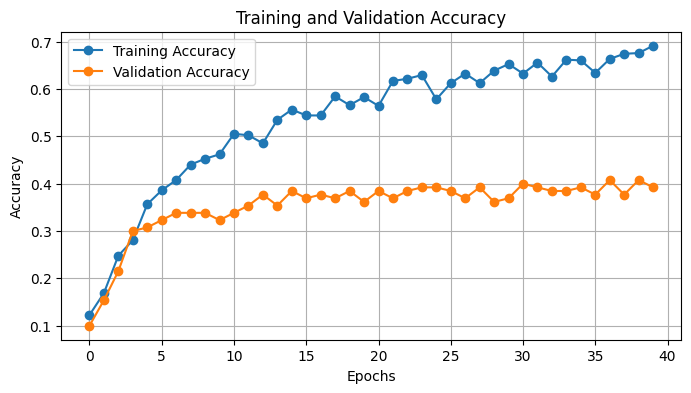

In [ ]:
def plot_accuracy(history):
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    plt.grid(True)
    plt.show()

plot_accuracy(history)

17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 208ms/step


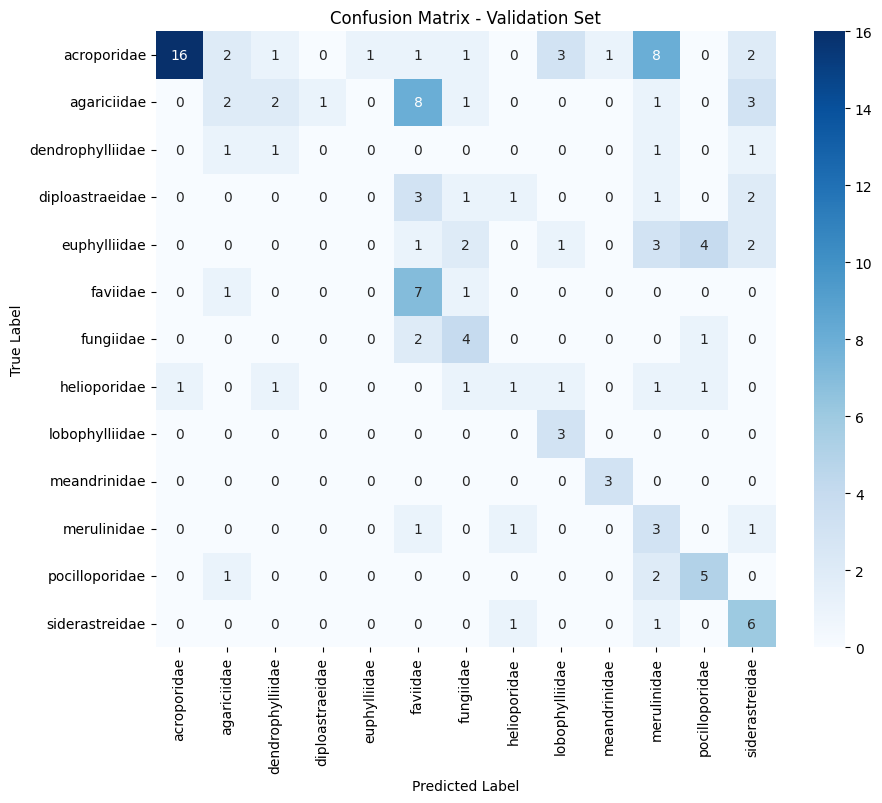

                  precision    recall  f1-score   support

     acroporidae       0.94      0.44      0.60        36
     agariciidae       0.29      0.11      0.16        18
dendrophylliidae       0.20      0.25      0.22         4
 diploastraeidae       0.00      0.00      0.00         8
    euphylliidae       0.00      0.00      0.00        13
        faviidae       0.30      0.78      0.44         9
       fungiidae       0.36      0.57      0.44         7
    helioporidae       0.25      0.14      0.18         7
  lobophylliidae       0.38      1.00      0.55         3
    meandrinidae       0.75      1.00      0.86         3
     merulinidae       0.14      0.50      0.22         6
  pocilloporidae       0.45      0.62      0.53         8
  siderastreidae       0.35      0.75      0.48         8

        accuracy                           0.39       130
       macro avg       0.34      0.47      0.36       130
    weighted avg       0.44      0.39      0.36       130



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Generate predictions for the validation set
# This returns probabilities, so we use argmax to obtain predicted class indices.
y_val_pred_probs = model.predict(val)
y_val_pred = np.argmax(y_val_pred_probs, axis=1)

# Extract the true labels from the validation dataset
y_val_true = []
for images, labels in val:
    # Convert labels from a tensor to a NumPy array and extend our list.
    y_val_true.extend(labels.numpy())
y_val_true = np.array(y_val_true)

# Compute the confusion matrix
cm = confusion_matrix(y_val_true, y_val_pred)

# Optional: if you have the label names (sorted list of unique labels), use them for tick labels
# For example, if defined earlier:
# label_names = sorted(set(labels_train))
# If not, you can omit xticklabels and yticklabels
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Validation Set")
plt.show()

# Print a detailed classification report
print(classification_report(y_val_true, y_val_pred, target_names=label_names))


# 5.2 Clip

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score


import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# Transformers for CLIP model and tokenizer
from transformers import CLIPProcessor, CLIPModel



from tqdm import tqdm  # progress bar

/root/DeepLearning2425/tf-gpu/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
train_df, val_df = train_test_split(cnidaria_train, test_size=0.2, random_state=42, stratify=cnidaria_train['family'])
test_df = cnidaria_test.copy()
print(f"Train samples: {len(train_df)}, Val samples: {len(val_df)}, Test samples: {len(test_df)}")

Train samples: 517, Val samples: 130, Test samples: 162


## Transformers

In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224))
])


## PyTorch Dataset

In [ ]:
import os
from PIL import Image
from torch.utils.data import Dataset

class RareSpeciesDataset(Dataset):
    def __init__(self, dataframe, transform, processor, root_dir, max_pixels=89478485):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform
        self.processor = processor  
        self.root_dir = root_dir
        self.max_pixels = max_pixels  # Example threshold; adjust as needed

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        full_image_path = os.path.join(self.root_dir, row['file_path'])
        
        try:
            image = Image.open(full_image_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {full_image_path}: {e}")
            # Optionally return a dummy image
            image = Image.new('RGB', (256, 256), (0, 0, 0))
        
        # Check if the image is very large, and if so, reduce resolution
        if image.size[0] * image.size[1] > self.max_pixels:
            # Halve both the width and the height
            new_size = (image.size[0] // 2, image.size[1] // 2)
            image = image.resize(new_size)
            print(f"Resized image {full_image_path} from {image.size} to {new_size}")
        
        # Now apply your transforms (which likely includes another resize step)
        image = self.transform(image)
        caption = f"a photo of {row['family']}"
        return image, caption


In [ ]:
from torch.utils.data.sampler import WeightedRandomSampler
import numpy as np

# Calculate frequency for each family within Cnidaria
family_counts = train_df['family'].value_counts().to_dict()

# Compute sample weights: weight = 1 / (frequency of the family)
weights = train_df['family'].apply(lambda x: 1.0 / family_counts[x]).values
weights = np.array(weights)

# Create the WeightedRandomSampler with replacement
sampler = WeightedRandomSampler(
    weights=weights,
    num_samples=len(weights),  # number of samples per epoch
    replacement=True
)

In [ ]:
def custom_collate_fn(batch):
    # batch is a list of tuples, where each tuple is (image, caption)
    images, captions = zip(*batch)
    # Return images and captions as lists (they remain as PIL images)
    return list(images), list(captions)

In [ ]:
# Initialize the CLIP processor from transformers
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")

# Assume that all your images are stored under the folder named "rare_species"
root_directory = "rare_species"

# Create dataset objects with the root_directory argument:
train_dataset = RareSpeciesDataset(train_df, train_transforms, processor, root_directory)
val_dataset   = RareSpeciesDataset(val_df, val_test_transforms, processor, root_directory)
test_dataset  = RareSpeciesDataset(test_df, val_test_transforms, processor, root_directory)

# Create the DataLoaders as before:
train_loader = DataLoader(train_dataset, batch_size=32, num_workers=0, collate_fn=custom_collate_fn, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0, collate_fn=custom_collate_fn)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


## Model Setup

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16").to(device)

In [ ]:
# # save the model
# model.save_pretrained("rare_species_clip_model")
# processor.save_pretrained("rare_species_clip_processor")

In [ ]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Load the model and processor
# model = CLIPModel.from_pretrained("rare_species_clip_model").to(device)
# processor = CLIPProcessor.from_pretrained("rare_species_clip_processor")

In [ ]:
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# num_epochs = 40  # Adjust the number of epochs as needed

# for epoch in range(num_epochs):
#     model.train()
#     total_loss = 0.0
#     for images, captions in train_loader:
#         # Process the list of PIL images and corresponding captions.
#         inputs = processor(text=captions, images=images, return_tensors="pt", padding=True)
#         # Move all inputs to the proper device
#         inputs = {k: v.to(device) for k, v in inputs.items()}
        
#         # Forward pass: get image and text embeddings from the model
#         outputs = model(**inputs)
#         image_embeds = outputs.image_embeds  # shape: [batch_size, embedding_dim]
#         text_embeds = outputs.text_embeds    # shape: [batch_size, embedding_dim]
        
#         # Normalize embeddings to unit norm
#         image_embeds = image_embeds / image_embeds.norm(dim=-1, keepdim=True)
#         text_embeds = text_embeds / text_embeds.norm(dim=-1, keepdim=True)
        
#         # Compute cosine similarity
#         logits_per_image = image_embeds @ text_embeds.t()
#         logits_per_text = text_embeds @ image_embeds.t()
        
#         # Ground truth: the i-th image should match the i-th text.
#         target = torch.arange(image_embeds.shape[0]).to(device)
        
#         loss_image = nn.CrossEntropyLoss()(logits_per_image, target)
#         loss_text  = nn.CrossEntropyLoss()(logits_per_text, target)
#         loss = (loss_image + loss_text) / 2
        
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
        
#         total_loss += loss.item()
        
#     avg_loss = total_loss / len(train_loader)
#     print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")


## Train and Evaluation

In [ ]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [ ]:
torch.backends.cudnn.benchmark = True

In [ ]:
import numpy as np
from sklearn.metrics import f1_score
import torch
from torch import nn
from tqdm import tqdm  # progress bar
from torch.amp import autocast, GradScaler  # new API usage

# Modified evaluation function remains unchanged
def evaluate_model(loader, model, processor, device):
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for images, captions in tqdm(loader, desc="Evaluating", leave=False):
            inputs = processor(text=captions, images=images, return_tensors="pt", padding=True)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            
            outputs = model(**inputs)
            image_embeds = outputs.image_embeds
            text_embeds  = outputs.text_embeds
            
            image_embeds = image_embeds / image_embeds.norm(dim=-1, keepdim=True)
            text_embeds  = text_embeds / text_embeds.norm(dim=-1, keepdim=True)
            
            sims = image_embeds @ text_embeds.t()
            
            preds = sims.argmax(dim=1).cpu().numpy()
            targets = np.arange(sims.shape[0])
            
            all_preds.extend(preds)
            all_targets.extend(targets)
            
    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)
    accuracy = np.mean(all_preds == all_targets)
    f1 = f1_score(all_targets, all_preds, average='macro')
    return accuracy, f1

# History lists for tracking metrics over epochs
num_epochs = 40
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scaler = GradScaler(device='cuda')  # Initialize the scaler with device_type

train_loss_history = [] 
train_acc_history, train_f1_history = [], []
val_acc_history, val_f1_history = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
    for images, captions in train_bar:
        optimizer.zero_grad()
        inputs = processor(text=captions, images=images, return_tensors="pt", padding=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        with autocast(device_type='cuda'):
            outputs = model(**inputs)
            image_embeds = outputs.image_embeds
            text_embeds  = outputs.text_embeds
            
            image_embeds = image_embeds / image_embeds.norm(dim=-1, keepdim=True)
            text_embeds  = text_embeds  / text_embeds.norm(dim=-1, keepdim=True)
            
            logits_per_image = image_embeds @ text_embeds.t()
            logits_per_text  = text_embeds @ image_embeds.t()
            
            target = torch.arange(image_embeds.shape[0]).to(device)
            
            loss_img = nn.CrossEntropyLoss()(logits_per_image, target)
            loss_txt = nn.CrossEntropyLoss()(logits_per_text, target)
            loss = (loss_img + loss_txt) / 2
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        running_loss += loss.item()
        train_bar.set_postfix(loss=loss.item())
    
    avg_loss = running_loss / len(train_loader)
    train_loss_history.append(avg_loss)
    
    train_accuracy, train_f1 = evaluate_model(train_loader, model, processor, device)
    val_accuracy, val_f1 = evaluate_model(val_loader, model, processor, device)
    
    train_acc_history.append(train_accuracy)
    train_f1_history.append(train_f1)
    val_acc_history.append(val_accuracy)
    val_f1_history.append(val_f1)
    
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f}")
    print(f"    Training   - Accuracy: {train_accuracy:.4f}, F1 Score: {train_f1:.4f}")
    print(f"    Validation - Accuracy: {val_accuracy:.4f}, F1 Score: {val_f1:.4f}")

# Save the model and processor
model.save_pretrained("rare_species_clip_model")
processor.save_pretrained("rare_species_clip_processor")

# Save the training history
import pandas as pd
history_df = pd.DataFrame({
    "train_loss": train_loss_history,
    "train_accuracy": train_acc_history,
    "train_f1": train_f1_history,
    "val_accuracy": val_acc_history,
    "val_f1": val_f1_history
})
history_df.to_csv("training_history.csv", index=False)

Epoch 1/40:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 1/40 - Loss: 3.3029
    Training   - Accuracy: 0.0484, F1 Score: 0.0331
    Validation - Accuracy: 0.0615, F1 Score: 0.0258


Epoch 2/40 - Loss: 3.1759
    Training   - Accuracy: 0.0542, F1 Score: 0.0362
    Validation - Accuracy: 0.0538, F1 Score: 0.0182


Epoch 3/40 - Loss: 3.2300
    Training   - Accuracy: 0.0484, F1 Score: 0.0374
    Validation - Accuracy: 0.0385, F1 Score: 0.0125


Epoch 4/40 - Loss: 3.2020
    Training   - Accuracy: 0.0522, F1 Score: 0.0387
    Validation - Accuracy: 0.0462, F1 Score: 0.0294


Epoch 5/40 - Loss: 3.2847
    Training   - Accuracy: 0.0658, F1 Score: 0.0534
    Validation - Accuracy: 0.0615, F1 Score: 0.0326


Epoch 6/40 - Loss: 3.1482
    Training   - Accuracy: 0.0503, F1 Score: 0.0443
    Validation - Accuracy: 0.0538, F1 Score: 0.0321


Epoch 7/40 - Loss: 3.1825
    Training   - Accuracy: 0.0619, F1 Score: 0.0422
    Validation - Accuracy: 0.0538, F1 Score: 0.0328


Epoch 8/40 - Loss: 3.1508
    Training   - Accuracy: 0.0638, F1 Score: 0.0564
    Validation - Accuracy: 0.0462, F1 Score: 0.0147


Epoch 9/40 - Loss: 3.1261
    Training   - Accuracy: 0.0735, F1 Score: 0.0584
    Validation - Accuracy: 0.0538, F1 Score: 0.0282


Epoch 10/40 - Loss: 3.1150
    Training   - Accuracy: 0.0638, F1 Score: 0.0478
    Validation - Accuracy: 0.0615, F1 Score: 0.0395


Epoch 11/40 - Loss: 3.1454
    Training   - Accuracy: 0.0619, F1 Score: 0.0465
    Validation - Accuracy: 0.0538, F1 Score: 0.0311


Epoch 12/40 - Loss: 3.1440
    Training   - Accuracy: 0.0870, F1 Score: 0.0661
    Validation - Accuracy: 0.0615, F1 Score: 0.0316


Epoch 13/40 - Loss: 3.1256
    Training   - Accuracy: 0.0600, F1 Score: 0.0404
    Validation - Accuracy: 0.0846, F1 Score: 0.0709


Epoch 14/40 - Loss: 3.1642
    Training   - Accuracy: 0.0561, F1 Score: 0.0477
    Validation - Accuracy: 0.0615, F1 Score: 0.0322


Epoch 15/40 - Loss: 3.1708
    Training   - Accuracy: 0.0658, F1 Score: 0.0553
    Validation - Accuracy: 0.0615, F1 Score: 0.0500


Epoch 16/40 - Loss: 3.1811
    Training   - Accuracy: 0.0735, F1 Score: 0.0604
    Validation - Accuracy: 0.0769, F1 Score: 0.0547


Epoch 17/40 - Loss: 3.1745
    Training   - Accuracy: 0.0580, F1 Score: 0.0466
    Validation - Accuracy: 0.0615, F1 Score: 0.0340


Epoch 18/40 - Loss: 3.1114
    Training   - Accuracy: 0.0696, F1 Score: 0.0562
    Validation - Accuracy: 0.0462, F1 Score: 0.0323


Epoch 19/40 - Loss: 3.1387
    Training   - Accuracy: 0.0677, F1 Score: 0.0512
    Validation - Accuracy: 0.0692, F1 Score: 0.0467


Epoch 20/40 - Loss: 3.0758
    Training   - Accuracy: 0.0638, F1 Score: 0.0436
    Validation - Accuracy: 0.0385, F1 Score: 0.0246


Epoch 21/40 - Loss: 3.1484
    Training   - Accuracy: 0.0561, F1 Score: 0.0390
    Validation - Accuracy: 0.0846, F1 Score: 0.0575


Epoch 22/40 - Loss: 3.2219
    Training   - Accuracy: 0.0658, F1 Score: 0.0481
    Validation - Accuracy: 0.0462, F1 Score: 0.0391


Epoch 23/40 - Loss: 3.3195
    Training   - Accuracy: 0.0309, F1 Score: 0.0192
    Validation - Accuracy: 0.0385, F1 Score: 0.0147


Epoch 24/40 - Loss: 3.3565
    Training   - Accuracy: 0.0290, F1 Score: 0.0145
    Validation - Accuracy: 0.0231, F1 Score: 0.0126


Epoch 25/40 - Loss: 3.3285
    Training   - Accuracy: 0.0271, F1 Score: 0.0144
    Validation - Accuracy: 0.0385, F1 Score: 0.0160


Epoch 26/40 - Loss: 3.3389
    Training   - Accuracy: 0.0193, F1 Score: 0.0095
    Validation - Accuracy: 0.0308, F1 Score: 0.0271


Epoch 27/40 - Loss: 3.2988
    Training   - Accuracy: 0.0290, F1 Score: 0.0157
    Validation - Accuracy: 0.0154, F1 Score: 0.0065


Epoch 28/40 - Loss: 3.3239
    Training   - Accuracy: 0.0193, F1 Score: 0.0138
    Validation - Accuracy: 0.0308, F1 Score: 0.0166


Epoch 29/40 - Loss: 3.3025
    Training   - Accuracy: 0.0445, F1 Score: 0.0326
    Validation - Accuracy: 0.0385, F1 Score: 0.0186


Epoch 30/40 - Loss: 3.2821
    Training   - Accuracy: 0.0387, F1 Score: 0.0286
    Validation - Accuracy: 0.0385, F1 Score: 0.0241


Epoch 31/40 - Loss: 3.2880
    Training   - Accuracy: 0.0619, F1 Score: 0.0469
    Validation - Accuracy: 0.0308, F1 Score: 0.0190


Epoch 32/40 - Loss: 3.2443
    Training   - Accuracy: 0.0561, F1 Score: 0.0439
    Validation - Accuracy: 0.0308, F1 Score: 0.0170


Epoch 33/40 - Loss: 3.2085
    Training   - Accuracy: 0.0812, F1 Score: 0.0757
    Validation - Accuracy: 0.0231, F1 Score: 0.0126


Epoch 34/40 - Loss: 3.1239
    Training   - Accuracy: 0.0948, F1 Score: 0.0719
    Validation - Accuracy: 0.0462, F1 Score: 0.0244


Epoch 35/40 - Loss: 3.1324
    Training   - Accuracy: 0.0851, F1 Score: 0.0715
    Validation - Accuracy: 0.0692, F1 Score: 0.0366


Epoch 36/40 - Loss: 3.1370
    Training   - Accuracy: 0.0851, F1 Score: 0.0748
    Validation - Accuracy: 0.0615, F1 Score: 0.0384


Epoch 37/40 - Loss: 3.1447
    Training   - Accuracy: 0.0561, F1 Score: 0.0381
    Validation - Accuracy: 0.0615, F1 Score: 0.0480


Epoch 38/40 - Loss: 3.1016
    Training   - Accuracy: 0.0716, F1 Score: 0.0519
    Validation - Accuracy: 0.0769, F1 Score: 0.0641


Epoch 39/40 - Loss: 3.0580
    Training   - Accuracy: 0.0754, F1 Score: 0.0573
    Validation - Accuracy: 0.0769, F1 Score: 0.0486


Epoch 40/40 - Loss: 3.0212
    Training   - Accuracy: 0.0735, F1 Score: 0.0566
    Validation - Accuracy: 0.0846, F1 Score: 0.0554


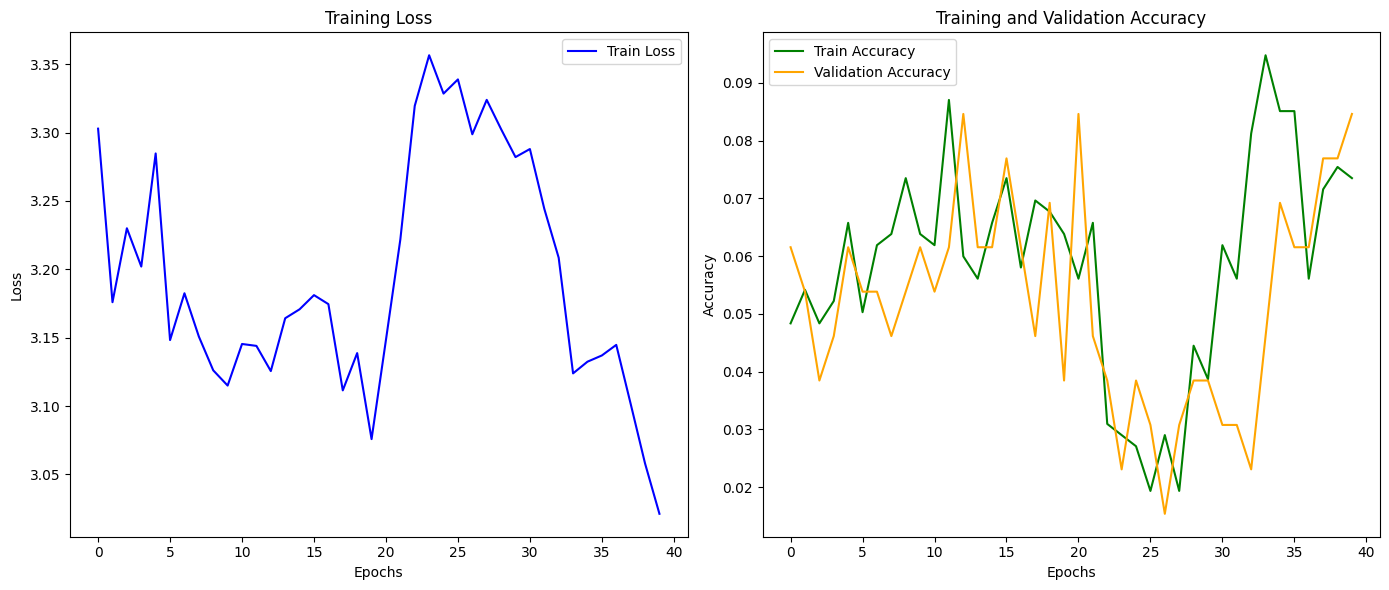

In [ ]:
#plot the training history and validation history
import matplotlib.pyplot as plt
import seaborn as sns
def plot_training_history(history_df):
    plt.figure(figsize=(14, 6))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history_df['train_loss'], label='Train Loss', color='blue')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history_df['train_accuracy'], label='Train Accuracy', color='green')
    plt.plot(history_df['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()
plot_training_history(history_df)